# Module Function Tests

This notebook tests individual functions and classes in the repository. Use these cells to verify that each module (utilities, feature extraction, HRV, advanced denoising, etc.) works as expected.

In [2]:
import sys
import os

# Get the repository root folder (assuming the notebook is in /your-project-root/notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import torch
import logging

from ecg_processor.config import ECGConfig
from ecg_processor.ecg_preprocessor import ECGPreprocessor
from ecg_processor.utils import create_bandpass_filter, create_notch_filter, normalize_signal
from ecg_processor.features import extract_statistical_features, extract_morphological_features
from ecg_processor.hrv import calculate_time_domain_hrv, calculate_frequency_domain_hrv
from ecg_processor.advanced_denoising import wavelet_denoise

logging.basicConfig(level=logging.DEBUG)
print('Modules imported successfully.')

Modules imported successfully.


## Test Utility Functions

We first test creation of filters and signal normalization.

In [3]:
# Create bandpass and notch filters
bp_b, bp_a = create_bandpass_filter(ECGConfig.FILTER_LOWCUT, ECGConfig.FILTER_HIGHCUT, ECGConfig.DEFAULT_SAMPLING_RATE, ECGConfig.FILTER_ORDER)
notch_b, notch_a = create_notch_filter(ECGConfig.NOTCH_FREQ, ECGConfig.NOTCH_Q, ECGConfig.DEFAULT_SAMPLING_RATE)
print('Bandpass filter coefficients:', bp_b[:5], '...', bp_a[:5])
print('Notch filter coefficients:', notch_b[:5], '...', notch_a[:5])

# Test normalization with an example signal
signal = np.linspace(-1, 1, 1000) + np.random.normal(0, 0.05, 1000)
normalized = normalize_signal(signal)
print('Normalized signal stats: mean =', normalized.mean(), ', std =', normalized.std())

Bandpass filter coefficients: [ 0.0021388   0.         -0.00855519  0.          0.01283279] ... [  1.          -6.69800177  19.67771811 -33.14948678  35.05040143]
Notch filter coefficients: [ 0.98963618 -1.60126497  0.98963618] ... [ 1.         -1.60126497  0.97927235]
Normalized signal stats: mean = 0.48915762946935903 , std = 0.266640510619028


## Test Feature Extraction Functions

Simulate a short ECG beat and extract statistical and morphological features.

In [4]:
# Simulate a beat (using a snippet of a simulated ECG signal)
beat = nk.ecg_simulate(duration=1, sampling_rate=ECGConfig.DEFAULT_SAMPLING_RATE, noise=0.01)

stat_features = extract_statistical_features(beat)
morph_features = extract_morphological_features(beat, ECGConfig.DEFAULT_SAMPLING_RATE)

print('Statistical features:', stat_features)
print('Morphological features:', morph_features)

/Users/linh/Downloads/ECGPreprocessor/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/linh/Downloads/ECGPreprocessor/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/linh/Downloads/ECGPreprocessor/.venv/lib/python3.13/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
ERROR:ecg_processor.features:Error extracting morphological features: The data length is too small to be segmented.


Statistical features: {'mean': 0.07087604561409103, 'std': 0.2609702374285791, 'max': 1.1749251219783745, 'min': -0.39730507410581833, 'median': -0.008259604726897662, 'mad': 0.0845461825730462, 'skewness': 1.9198597151194483, 'kurtosis': 4.94649239816602, 'peak_factor': 4.344759413155115, 'energy': 36.56443933270984, 'rms': 0.2704235172196007, 'peak_to_rms': 4.344759413155115, 'entropy': 2.411021003651366, 'zero_crossings': 8, 'range': 1.572230196084193, 'variance': 0.06810546482352896}
Morphological features: {}


## Test HRV Calculation Functions

We simulate R-peaks and compute HRV metrics.

In [5]:
# Create artificial R-peak positions
r_peaks = np.array([100, 600, 1100, 1600, 2100])
rr_intervals = np.diff(r_peaks) / ECGConfig.DEFAULT_SAMPLING_RATE * 1000  # ms

time_hrv = calculate_time_domain_hrv(rr_intervals)
freq_hrv = calculate_frequency_domain_hrv(rr_intervals)
print('Time domain HRV:', time_hrv)
print('Frequency domain HRV:', freq_hrv)

Time domain HRV: {'mean_hr': np.float64(60.0), 'sdnn': 0.0, 'rmssd': 0.0, 'pnn50': 0.0, 'mean_rr': 1000.0, 'sdsd': 0.0}
Frequency domain HRV: {'vlf_power': 0.0, 'lf_power': 0.0, 'hf_power': 0.0, 'lf_hf_ratio': 0.0, 'total_power': 0.0, 'lf_nu': 0.0, 'hf_nu': 0.0, 'peak_vlf': 0.0, 'peak_lf': 0.0, 'peak_hf': 0.3333333333333333}


## Test Advanced Denoising Function

Apply wavelet denoising to a simulated noisy ECG snippet.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


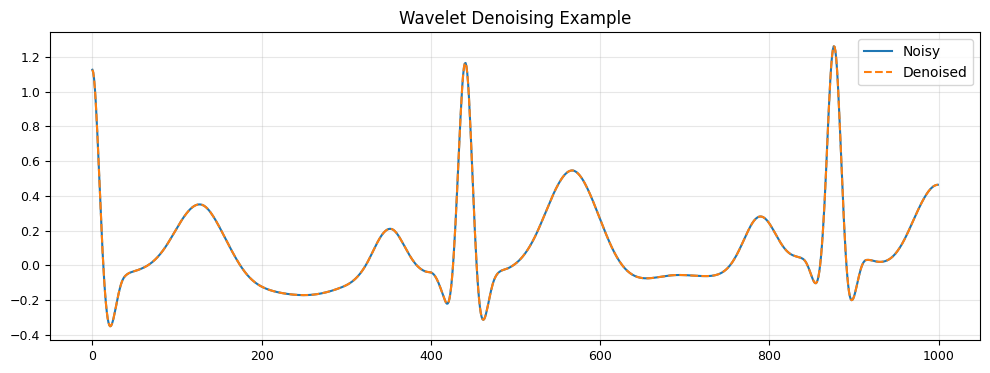

In [7]:
# Simulate a noisy ECG signal (this returns a NumPy array)
noisy_signal = nk.ecg_simulate(duration=2, sampling_rate=ECGConfig.DEFAULT_SAMPLING_RATE, noise=0.1)

# Convert the noisy signal (if needed) to a PyTorch tensor then back to NumPy, or simply use the NumPy array:
# Option A: Use directly if calling a NumPy-based function:
denoised_signal = wavelet_denoise(noisy_signal)

# Option B: If your workflow prefers using torch tensors elsewhere:
noisy_signal_tensor = torch.tensor(noisy_signal, dtype=torch.float32)
# Convert to NumPy array for the denoising function:
denoised_signal = wavelet_denoise(noisy_signal_tensor.detach().cpu().numpy())

# Plotting the result:
plt.figure(figsize=(12,4))
plt.plot(noisy_signal, label='Noisy')
plt.plot(denoised_signal, label='Denoised', linestyle='--')
plt.legend()
plt.title('Wavelet Denoising Example')
plt.show()

## Conclusion

These tests help ensure each module function works as expected. Use and expand these cells as needed for further testing.